Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Martin Knap"
COLLABORATORS = ""

---

# Domača naloga 6: Geometrijska kalibracija kamere

1. Napišite funkcijo, ki za dane optimalne parametre geometrijske kalibracije `iPar` normalizira zajeto sliko `iImage` v metrični prostor:
```python
    def geomCalibImage( iPar, iImage, iCoorX, iCoorY ):
        return oImage
```
kjer spremenljivki `iCoorX` in `iCoorY` predstavljata koordinate točk $(x,y)$ **v metričnem prostoru**, ki jih je potrebno preslikati v prostor slike in določiti pripadajoče sivinske vrednosti. Funkcija vrne kalibrirano sliko `oImage`, katere dimenzije so podane glede na dimenzije vzorčnih točk $(x,y)$.

 Preverite delovanje funkcije tako, da vzorčne točke $(x,y)$ preslikate z optimalnimi parametri projektivne preslikave in modela radialnih distorzij. Predpostavite, da ima stranica kvadratnega polja kalibracijskega objekta dolžino 20 mm in ustvarite točke $(x,y)$ tako, da bo na izhodni kalibrirani sliki `oImage` velikost slikovnih elementov enaka $1/5\,$ mm. Izvedite geometrijsko kalibracijo slike `data/calibration-object.jpg` tako, da s funkcijo za interpolacijo prvega reda (bilinearno) `scipy.interpolate.interpn()` v preslikanih točkah poiščete nove sivinske vrednosti. Prikažite preslikano sliko, v kateri morajo biti vzorci v kalibru poravnani z osmi slike.

Naložite module in prilepite zahtevane funkcije iz vaj:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as im
from scipy.interpolate import interpn
import cv2 as cv

def loadImage(iPath):
    oImage = np.array(im.open(iPath))
    return oImage

def showImage(iImage, iTitle=''):
    plt.figure()
    plt.imshow(iImage, cmap = 'gray')
    plt.suptitle(iTitle)
    plt.xlabel('x')
    plt.ylabel('y')

def colorToGray(iImage):
    dtype = iImage.dtype
    r = iImage[:,:,0].astype('float')
    g = iImage[:,:,1].astype('float')
    b = iImage[:,:,2].astype('float')
    
    return (r*0.299 + g*0.587 + b*0.114).astype(dtype)

def addHomCoord2D(iPts):
    if iPts.shape[-1] == 3:
        return iPts
    iPts = np.hstack((iPts, np.ones((iPts.shape[0], 1))))
    return iPts

def mapAffineApprox2D(iPtsRef, iPtsMov):
    """Afina aproksimacijska poravnava"""
    iPtsRef = np.matrix(iPtsRef) 
    iPtsMov = np.matrix(iPtsMov) 

    iPtsRef = addHomCoord2D(iPtsRef)
    iPtsMov = addHomCoord2D(iPtsMov)

    iPtsRef = iPtsRef.transpose()
    iPtsMov = iPtsMov.transpose()            
    oMat2D = iPtsRef * iPtsMov.transpose() * \
    np.linalg.inv( iPtsMov * iPtsMov.transpose() )
    return oMat2D

def transRadial( iK, iUc, iVc, iCoorU, iCoorV ):
    """Funkcija za preslikavo z Brownovim modelom distorzij"""    
    iK = np.array( iK )
    iCoorU = np.array( iCoorU )
    iCoorV = np.array( iCoorV )
    if np.size(iCoorU) != np.size(iCoorV):
        print('Stevilo U in V koordinat je razlicno!')
    oCoorUd = iCoorU - iUc; oCoorVd = iCoorV - iVc
    sUd = np.max( np.abs( oCoorUd ) )
    sVd = np.max( np.abs( oCoorVd ) )
    oCoorUd = oCoorUd / sUd
    oCoorVd = oCoorVd / sVd
    R2 = oCoorUd**2.0 + oCoorVd**2.0
    iK = iK.flatten()
    oCoorRd = np.ones_like( oCoorUd )
    for i in range(iK.size):
        oCoorRd = oCoorRd + iK[i]*(R2**(i+1))
    oCoorUd = oCoorUd * oCoorRd * sUd + iUc
    oCoorVd = oCoorVd * oCoorRd * sVd + iVc
    return oCoorUd, oCoorVd

def transProjective2D( iPar, iCoorX, iCoorY ):
    """Funkcija za projektivno preslikavo"""
    iPar = np.asarray( iPar )
    iCoorX = np.asarray( iCoorX )
    iCoorY = np.asarray( iCoorY )
    if np.size(iCoorX) != np.size(iCoorY):
        print('Stevilo X in Y koordinat je razlicno!')
    oDenom = iPar[6] * iCoorX + iPar[7] * iCoorY + 1
    oCoorU = iPar[0] * iCoorX + iPar[1] * iCoorY + iPar[2]
    oCoorV = iPar[3] * iCoorX + iPar[4] * iCoorY + iPar[5]
    return oCoorU/oDenom, oCoorV/oDenom

def geomCalibTrans( iPar, iCoorX, iCoorY ):
    """Funkcija za preslikavo tock (projektivna+radialne distorzije)"""
    iParProj = iPar[0:8]
    iParRad = iPar[8:]
    iCoorUt, iCoorVt = transProjective2D( iParProj, iCoorX, iCoorY )
    iCoorUt, iCoorVt = transRadial(iParRad[2:], iParRad[0], iParRad[1], iCoorUt, iCoorVt)
    return iCoorUt, iCoorVt

def geomCalibTrans( iPar, iCoorX, iCoorY ):
    """Funkcija za preslikavo tock (projektivna+radialne distorzije)"""
    iParProj = iPar[0:8]
    iParRad = iPar[8:]
    iCoorUt, iCoorVt = transProjective2D( iParProj, iCoorX, iCoorY )
    iCoorUt, iCoorVt = transRadial(iParRad[2:], iParRad[0], iParRad[1], iCoorUt, iCoorVt)
    return iCoorUt, iCoorVt

def geomCalibErr( iPar, iCoorU, iCoorV, iCoorX, iCoorY):
    """Funkcija za izracun kalibracijske napake"""
    iCoorUt, iCoorVt = geomCalibTrans( iPar, iCoorX, iCoorY )
    oErr2 = np.mean( (iCoorU-iCoorUt)**2 + (iCoorV-iCoorVt)**2 )
    return oErr2

Implementirajte funkcijo `geomCalibImage`:

In [4]:
def geomCalibImage( iPar, iImage, iCoorX, iCoorY ):
    """Funkcija za normalizacijo slike po geometrijski kalibraciji"""
    #projektivna preslikava
    oCoorU, oCoorV = transProjective2D(iPar, iCoorX, iCoorY)
    
    s = 1
    dy, dx = iImage.shape
    oImage = interpn((np.arange(dy), np.arange(dx)), iImage, (oCoorV[::s,::s], oCoorU[::s,::s]), method = "linear", bounds_error=False)
    oImage = oImage.astype('int')
    #print(oImage)
    iMax = np.max(iImage)
    iMin = np.min(iImage)
    #print(iMax, iMin)
    
    oImage[oImage > iMax] = iMax
    oImage[oImage < iMin] = iMin
    
    #print(oImage)
    
    return oImage

 Preverite delovanje funkcije tako, da vzorčne točke $(x,y)$ preslikate z optimalnimi parametri projektivne preslikave in modela radialnih distorzij. Predpostavite, da ima stranica kvadratnega polja kalibracijskega objekta dolžino 20 mm in ustvarite točke $(x,y)$ tako, da bo na izhodni kalibrirani sliki `oImage` velikost slikovnih elementov enaka $1/5\,$ mm. Izvedite geometrijsko kalibracijo slike `data/calibration-object.jpg` tako, da s funkcijo za interpolacijo prvega reda `scipy.interpolate.interpn()` v preslikanih točkah poiščete nove sivinske vrednosti. Prikažite preslikano sliko, v kateri morajo biti vzorci v kalibru poravnani z osmi slike.

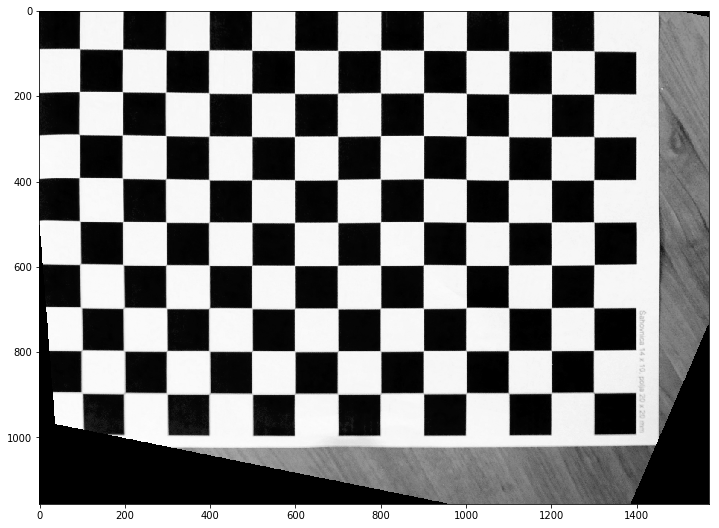

In [5]:
# Slika kalibracijskega objekta
iCalImage = loadImage('data/calibration-object.jpg')
iCalImage = colorToGray(iCalImage)
# plt.figure()
# plt.imshow(iCalImage, cmap='gray')
# Primer parametrov -- vzemite parametre, ki ste jih dolocili na vaji
iPar = [4.452, -0.349, 34.207, -0.709,
        3.352, 211.927, 2.459e-04, -1.348e-03,
        1963.270, 1478.125, 1.101e-03]

dx, dy = iCalImage.shape
pixSize = 1/5
iCoorX, iCoorY = np.meshgrid(np.arange(0, dx-1, pixSize), np.arange(0, dy-1, pixSize), sparse=False, indexing='xy')

TransImage = geomCalibImage(iPar, iCalImage, iCoorX, iCoorY)

plt.figure(figsize=(12,12))
plt.imshow(TransImage[0:dx,0:dy], cmap='gray')

2. Barvno sliko objekta `data/test-object.jpg`, ki je bila zajeta z istim slikovnim sistemom kot slika kalibra, kalibrirajte z referenčno geometrijsko kalibracijo tako, da bo velikost slikovnega elementa enaka $1/3\,$ mm. Prikažite kalibrirano barvno sliko in nato na merilu označite daljico med kljunoma kljunastega merila ter izračunajte njeno dolžino v mm. Preverite ali dolžina ustreza dolžini, ki je označena na kljunastem merilu.


In [6]:
def geomCalibImageCol( iPar, iImage, iCoorX, iCoorY ):
    """Funkcija za normalizacijo slike po geometrijski kalibraciji"""
    #projektivna preslikava
    oCoorU, oCoorV = transProjective2D(iPar, iCoorX, iCoorY)    
    s = 1
    dy, dx, dz = iImage.shape
    oImage = interpn((np.arange(dy), np.arange(dx)), iImage, (oCoorV[::s,::s], oCoorU[::s,::s]), method = "linear", bounds_error=False)
    oImage = oImage.astype('int')
    iMax = np.max(iImage)
    iMin = np.min(iImage)    
    oImage[oImage > iMax] = iMax
    oImage[oImage < iMin] = iMin       
    return oImage

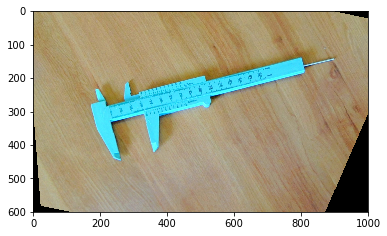

In [7]:
# Kalibrirajte sliko, jo prikazite in na njej oznacite tocki, 
# ki dolocata razdaljo med kljunoma
CALIBpers = loadImage('data/test-object.jpg')

iPar = [4.452, -0.349, 34.207, -0.709,
        3.352, 211.927, 2.459e-04, -1.348e-03,
        1963.270, 1478.125, 1.101e-03]

dx, dy, dz = CALIBpers.shape
pixSize = 1/3
iCoorX, iCoorY = np.meshgrid(np.arange(0, dx-1, pixSize), np.arange(0, dy-1, pixSize), sparse=False, indexing='xy')
TransCALIBpers = geomCalibImageCol(iPar, CALIBpers, iCoorX, iCoorY)
TransCALIBpers = TransCALIBpers[0:600,0:1000]
TransCALIBpers = TransCALIBpers.astype(np.uint8)
plt.figure()
plt.imshow(TransCALIBpers)

#TransCALIBpers = im.fromarray(TransCALIBpers.astype(np.uint8))
TransCALIBpers = im.fromarray(TransCALIBpers)
TransCALIBpers.save('./data/TransCALIBpers.jpg')

<IPython.core.display.Javascript object>


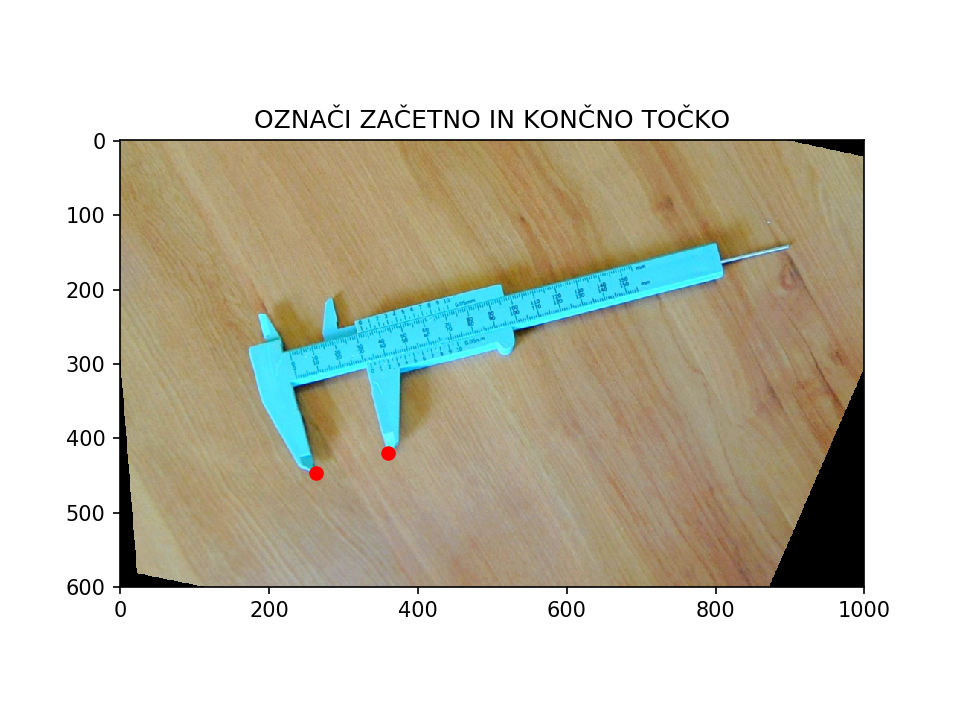

In [8]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(TransCALIBpers)
plt.title('OZNAČI ZAČETNO IN KONČNO TOČKO')

points = []
def onclick(event):
    if event.key == 'shift':
        x, y = event.xdata, event.ydata
        points.append((x, y))
        ax.plot(x, y, 'or')
        fig.canvas.draw()
    
ka = fig.canvas.mpl_connect('button_press_event', onclick)

In [9]:
CalibPoints = points
points = np.round(points)
points = points.astype('int')
#points = tuple(points)
print(tuple(points[0]))
print(tuple(points[1]))

(263, 446)
(360, 420)


<IPython.core.display.Javascript object>


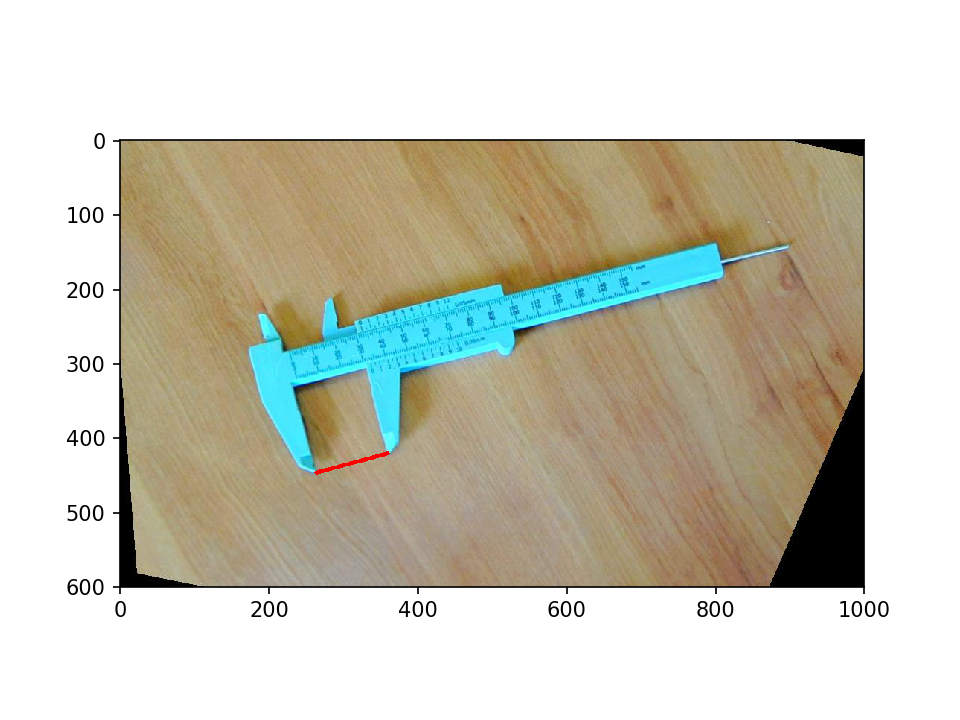

In [10]:
Calib = loadImage('./data/TransCALIBpers.jpg')
CalibLine = cv.line(Calib, tuple(points[0]), tuple(points[1]), (255,0,0),3)
plt.figure()
plt.imshow(CalibLine)

In [11]:
# Izracunajte in izpisite izmerejeno razdaljo med kljunoma
start_point = CalibPoints[0]
end_point = CalibPoints[1]
#print(start_point[1])
CALIBpersLength = np.sqrt((start_point[0]-end_point[0])**2 + (start_point[1]-end_point[1])**2)*1/3
print('Dolžina odprtega merila znaša:',CALIBpersLength,'milimetrov.')

Dolžina odprtega merila znaša: 33.420206341818194 milimetrov.


3. Geometrijsko kalibracijo ponovite $3\times$ tako, da najprej $3\times$ ročno označite oglišča na sliki s kalibracijskim objektom `data/calibration-object.jpg`. Referenčno geometrijsko kalibracijo nato določite glede na povprečne koordinate teh oglišč. Na podlagi referenčne geometrijske kalibracije ocenite točnost geometrijske kalibracije z ročno označenimi oglišči (tiste geometrijske kalibracije, ki ste jo izračunali na vajah) v milimetrih. Od česa zavisi točnost geometrijske kalibracije?

<IPython.core.display.Javascript object>


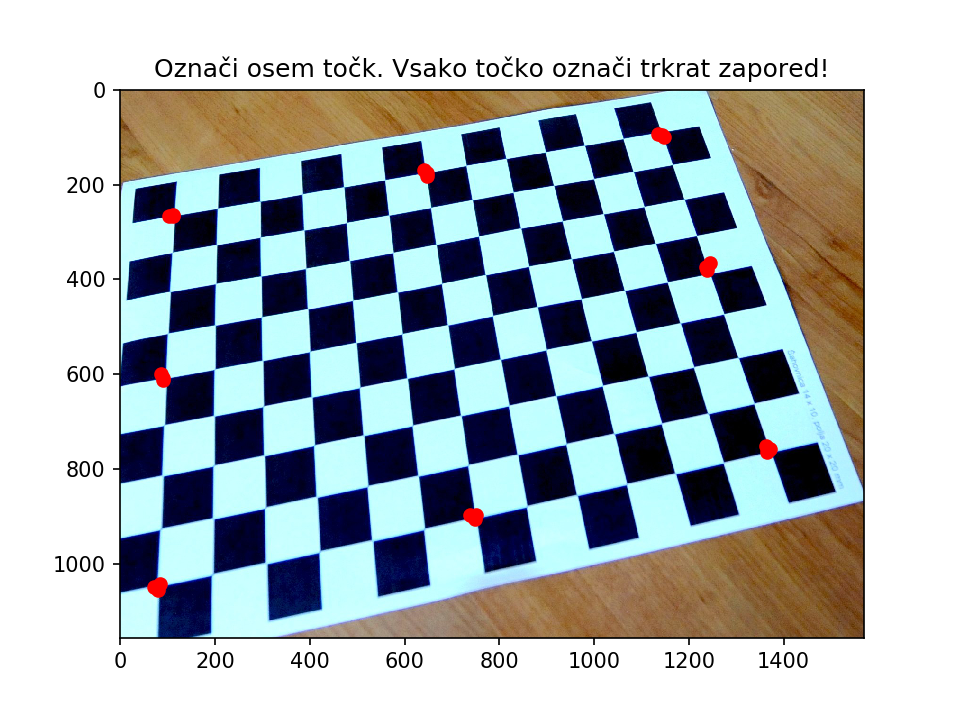

In [215]:
# Oznacite oglisca na sliki (vsako oglisce 3 krat)
CalibObj = loadImage('data/calibration-object.jpg')

%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(CalibObj)
plt.title('Označi osem točk. Vsako točko označi trkrat zapored!')

points = []
def onclick(event):
    if event.key == 'shift':
        x, y = event.xdata, event.ydata
        points.append((x, y))
        ax.plot(x, y, 'or')
        fig.canvas.draw()
    
ka = fig.canvas.mpl_connect('button_press_event', onclick)


povp. točke: 
 [[ 108.572  265.076]
 [ 644.566  174.337]
 [ 1141.522  95.204]
 [ 1239.647  372.697]
 [ 1366.260  756.756]
 [ 745.857  899.196]
 [ 77.974  1047.966]
 [ 88.525  605.876]]


<IPython.core.display.Javascript object>


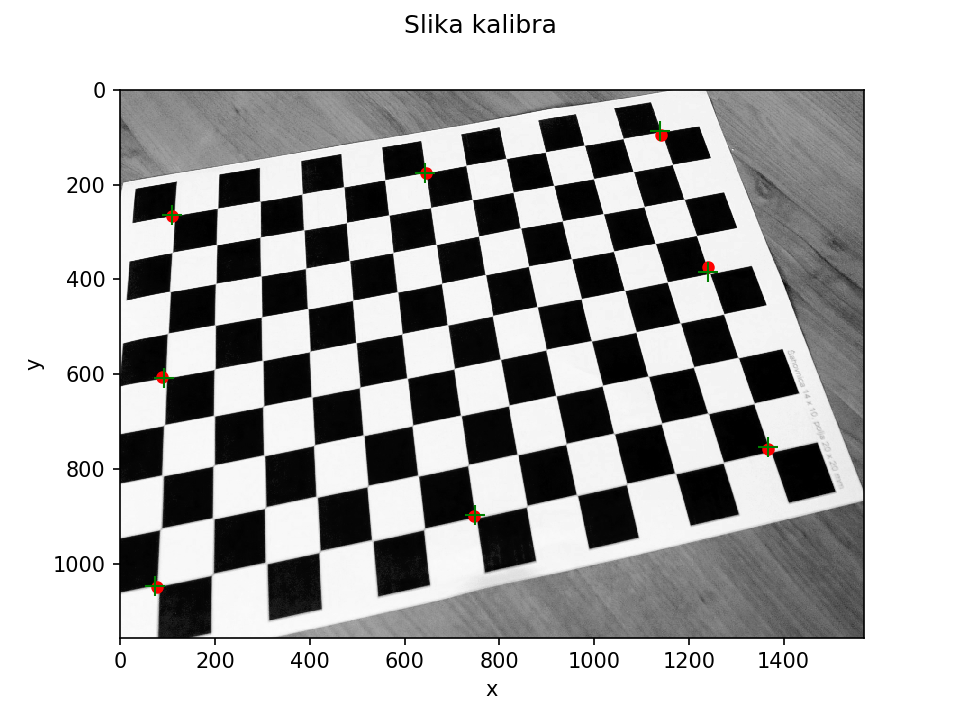

ident err:  702652.1481290277
affine err:  3113.8003346327077
Iter   [a11 a12 tx a21 a22 ty px py uc vc k]   f(X)     
  20    4.798   0.608  -60.417  -0.958   4.499  207.559              7.468e-05  -1.527e-04   750.908   601.383  1.752e-04    2616.014731
  40    4.816   0.544  -57.679  -0.936   4.377  196.997              2.146e-04  -4.279e-04   820.043   598.829  5.850e-04    2084.651879
  60    4.844   0.502  -57.962  -0.900   4.307  198.352              1.979e-04  -5.125e-04   843.110   609.240  1.030e-03    1761.209515
  80    4.941   0.336  -60.655  -0.749   4.136  181.079              3.300e-04  -7.746e-04  1008.556   612.257  1.471e-03    1194.735582
 100    4.985   0.216  -60.703  -0.699   4.046  173.597              3.588e-04  -8.820e-04  1097.936   607.604  1.887e-03    1114.360091
 120    4.974   0.219  -54.284  -0.676   3.946  175.411              3.919e-04  -9.340e-04  1090.238   673.318  1.960e-03    953.565488
 140    4.952   0.219  -47.543  -0.688   3.843  186.288     

2100    4.538  -0.324  25.212  -0.695   3.363  215.397              3.079e-04  -1.328e-03   701.996  2435.459  2.930e-03    32.945623
2120    4.538  -0.324  25.167  -0.695   3.363  215.321              3.078e-04  -1.328e-03   702.001  2440.787  2.901e-03    32.944466
2140    4.537  -0.324  25.170  -0.695   3.363  215.356              3.075e-04  -1.328e-03   703.333  2440.197  2.901e-03    32.942921
2160    4.538  -0.323  25.032  -0.695   3.365  215.247              3.078e-04  -1.327e-03   703.093  2444.385  2.866e-03    32.940335
2180    4.539  -0.323  24.964  -0.696   3.365  215.197              3.077e-04  -1.327e-03   706.595  2454.199  2.804e-03    32.936317
2200    4.538  -0.323  25.017  -0.696   3.365  215.221              3.075e-04  -1.327e-03   715.681  2469.854  2.709e-03    32.930448
2220    4.538  -0.323  25.015  -0.697   3.366  215.196              3.074e-04  -1.327e-03   719.563  2476.628  2.664e-03    32.926299
2240    4.539  -0.323  25.013  -0.697   3.366  215.137        

3520    4.538  -0.323  25.031  -0.698   3.366  215.071              3.058e-04  -1.327e-03   719.433  2507.666  2.540e-03    32.896549
3540    4.538  -0.323  25.031  -0.698   3.366  215.071              3.058e-04  -1.327e-03   719.433  2507.648  2.540e-03    32.896549
3560    4.538  -0.323  25.031  -0.698   3.366  215.071              3.058e-04  -1.327e-03   719.433  2507.662  2.540e-03    32.896549
3580    4.538  -0.323  25.031  -0.698   3.366  215.071              3.058e-04  -1.327e-03   719.433  2507.662  2.540e-03    32.896549
3600    4.538  -0.323  25.031  -0.698   3.366  215.071              3.058e-04  -1.327e-03   719.433  2507.664  2.540e-03    32.896549
3620    4.538  -0.323  25.031  -0.698   3.366  215.071              3.058e-04  -1.327e-03   719.433  2507.658  2.540e-03    32.896549
3640    4.538  -0.323  25.031  -0.698   3.366  215.071              3.058e-04  -1.327e-03   719.433  2507.660  2.540e-03    32.896549
3660    4.538  -0.323  25.031  -0.698   3.366  215.071        

zacetni parametri:   4.823   0.615  -60.114  -0.964   4.519  210.196     0.000e+00  0.000e+00   785.000   578.000  0.000e+00
koncni parametri:   4.538  -0.323  25.029  -0.698   3.366  215.068     3.058e-04  -1.327e-03   719.433  2507.879  2.539e-03
[ 108.897  643.179  1139.576  1240.165  1366.326  748.877  72.801  93.075] [ 264.116  176.114  87.078  383.330  753.874  897.737  1046.727  608.192]


In [233]:
#povprečenje točk
pts_x = []; pts_y = []
for i in range(len(points)):
    pts_x.append(points[i][0])
    pts_y.append(points[i][1])

pts_x = np.array(pts_x)
pts_y = np.array(pts_y)
Points = np.array([pts_x.transpose(), pts_y.transpose()]).transpose()

j = 1
grp_pts = []
avg_pts = []
for i in range(len(Points[:,0])):
    grp_pts.append(Points[i, :])
    if (j == 3):
        grp_pts = np.array(grp_pts)
        avg_grp_pts = np.mean(grp_pts, axis=0)
        avg_pts.append(avg_grp_pts)
        j = 0
        grp_pts = []
    j += 1
    
avg_pts = np.array(avg_pts)
print('povp. točke: \n', avg_pts)

#1. del
pts = avg_pts
CalibObjGray = colorToGray(CalibObj)
showImage( CalibObjGray, 'Slika kalibra' )
plt.plot(pts[:,0], pts[:,1], 'or', markersize=5.0)        
iCoorU = pts[:,0].flatten()
iCoorV = pts[:,1].flatten()
iCoorX = np.array([20, 140, 260, 260, 260, 140,  20,  20])
iCoorY = np.array([20,  20,  20, 100, 180, 180, 180, 100])
ptsUV = np.vstack( (iCoorU, iCoorV) ).transpose()
ptsXY = np.vstack( (iCoorX, iCoorY) ).transpose()
oMatA = mapAffineApprox2D( ptsUV, ptsXY )
Uc = CalibObjGray.shape[1]/2
Vc = CalibObjGray.shape[0]/2
iParIdent = np.array([1,0,0,0,1,0,0,0,Uc,Vc,0])
Uc = CalibObjGray.shape[1]/2
Vc = CalibObjGray.shape[0]/2
iParAffine = np.array([oMatA[0,0], oMatA[0,1], oMatA[0,2],\
                       oMatA[1,0], oMatA[1,1], oMatA[1,2],\
                       0, 0, Uc, Vc, 0])
oErr2ident = geomCalibErr( iParIdent, iCoorU, iCoorV, iCoorX, iCoorY )
oErr2affine = geomCalibErr( iParAffine, iCoorU, iCoorV, iCoorX, iCoorY )
print('ident err: ', oErr2ident)
print('affine err: ', oErr2affine)

#2. del        
Nfeval = 1   
step = 50
def callbackF(Xi):
    global Nfeval
    if Nfeval % 20 == 0:
        np.set_printoptions(formatter={'float': '{: 0.3f}'.format})
        formattedline = '%6.3f  %6.3f  %6.3f  %6.3f  %6.3f  %6.3f  \
            %8.3e  %8.3e  %8.3f  %8.3f  %8.3e' % ( tuple(Xi[:]) )
        print('{0:4d}   {1}   {2: 3.6f}'.format(Nfeval, formattedline, F(Xi)))
    Nfeval += 1

Nfeval = 1
from scipy.optimize import fmin
F = lambda x: geomCalibErr( x, iCoorU, iCoorV, iCoorX, iCoorY )#funkcija
print('{0:4s}   {1:20s}   {2:9s}'.format('Iter', 
      '[a11 a12 tx a21 a22 ty px py uc vc k]', 'f(X)'))
iParOpt = fmin(func=F, x0=iParAffine, maxiter=5000, disp=1, xtol=1e-6, 
               ftol=1e-6, callback=callbackF, maxfun=None )
formattedline1 = '%6.3f  %6.3f  %6.3f  %6.3f  %6.3f  %6.3f \
    %8.3e  %8.3e  %8.3f  %8.3f  %8.3e' % ( tuple(iParAffine[:]) )
formattedline2 = '%6.3f  %6.3f  %6.3f  %6.3f  %6.3f  %6.3f \
    %8.3e  %8.3e  %8.3f  %8.3f  %8.3e' % ( tuple(iParOpt[:]) )
print('zacetni parametri: ', formattedline1)
print('koncni parametri: ', formattedline2)     

iCoorUt, iCoorVt = geomCalibTrans( iParOpt, iCoorX, iCoorY )
plt.plot(iCoorUt, iCoorVt, '+g', markersize=10.0)
print(iCoorUt, iCoorVt)

<IPython.core.display.Javascript object>


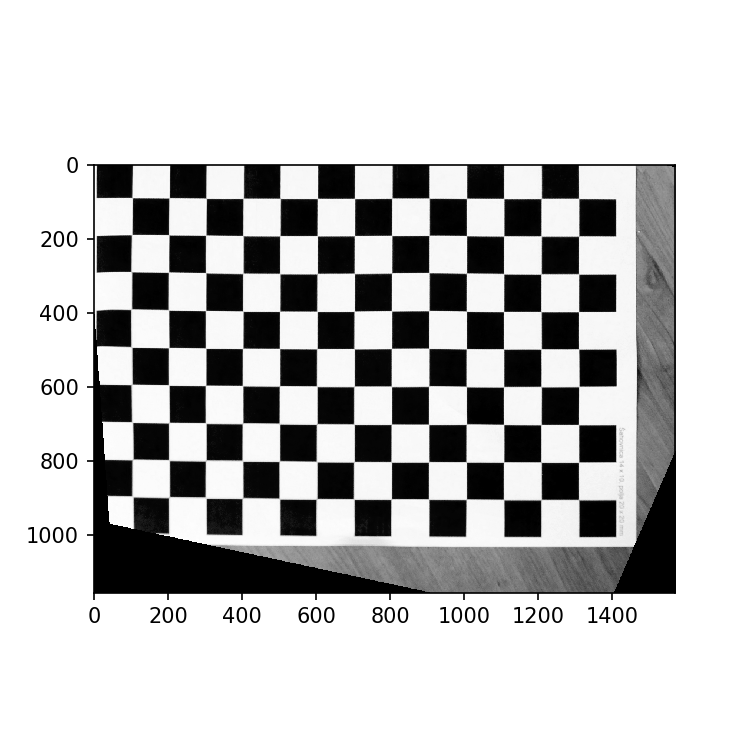

In [232]:
dx, dy = CalibObjGray.shape
pixSize = 1/5
iCoorX, iCoorY = np.meshgrid(np.arange(0, dx-1, pixSize), np.arange(0, dy-1, pixSize), sparse=False, indexing='xy')

TransImage = geomCalibImage(iParOpt, CalibObjGray, iCoorX, iCoorY)

plt.figure(figsize=(5,5))
plt.imshow(TransImage[0:dx,0:dy], cmap='gray')

<IPython.core.display.Javascript object>


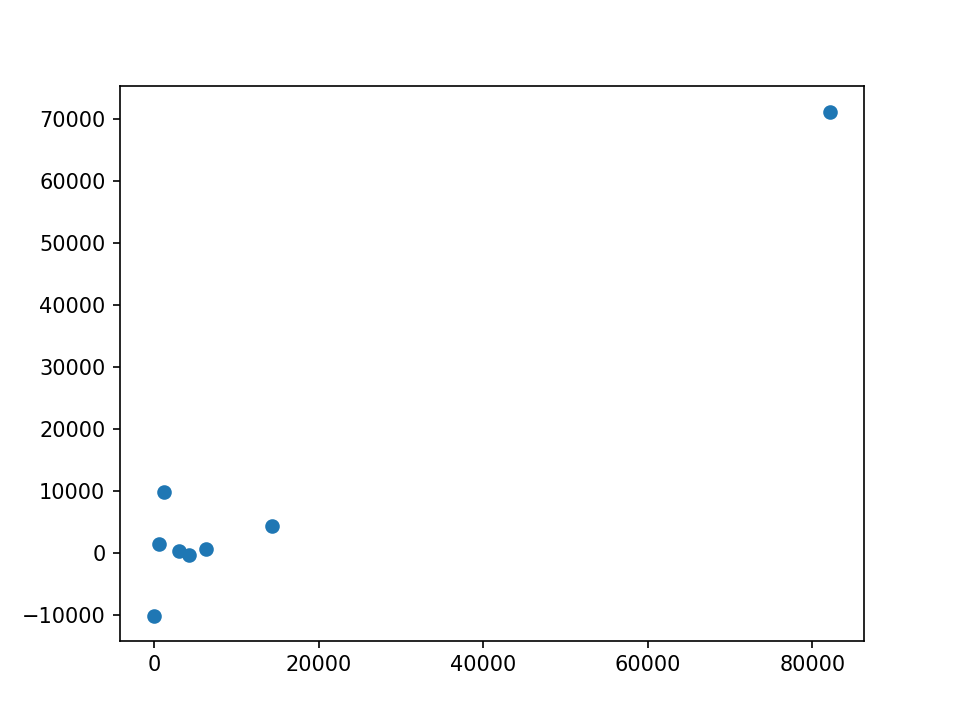

[ 635.137  2997.314  4191.384  6349.141  14316.078  82154.641 -46.132
  1130.948]
[ 1505.500  372.634 -233.134  734.576  4305.848  71179.906 -10069.373
  9913.352]


In [289]:
# Z dobljeno referencno kalibracijo ocenite tocnost 
# geometrijske kalibracije iz vaj v milimetrih
refImage = TransImage

# x_ref = np.zeros_like(iCoorUt)
# y_ref = np.zeros_like(iCoorVt)
# for i in range(len(iCoorUt)):
#     x_ref[i] = (iParOpt[0]*iCoorUt[i] + iParOpt[1]*iCoorVt[i] + iParOpt[2])/(iParOpt[6]*iCoorUt[i] + iParOpt[7]*iCoorVt[i]+1)
#     y_ref[i] = (iParOpt[3]*iCoorUt[i] + iParOpt[4]*iCoorVt[i] + iParOpt[5])/(iParOpt[6]*iCoorUt[i] + iParOpt[7]*iCoorVt[i]+1)

# plt.figure()
# plt.scatter(x_ref, y_ref)

ref_x, ref_y = transProjective2D(iParOpt, iCoorUt, iCoorVt)
plt.figure()
plt.scatter(ref_x, ref_y)
print(ref_x)
print(ref_y)

#TODO: INVERZNI PARAMETRI?

Od česa zavisi točnost kalibracije?

YOUR ANSWER HERE

4. Razvijte avtomatski postopek za geometrijsko kalibracijo slikovnega sistema. S pomočjo Harrisovega detektorja oglišč iz knjižnice OpenCV (Vaja 4) poiščite oglišča na sliki kalibra `data/calibration-object.jpg`. Nato pa s funkcijo `cv2.cornerSubPix()` še dodatno izpopolnite položaj oglišč. Ustvarite idealno mrežo referenčnih oglišč in s postopkom ICP (Vaja 5) ter afino preslikavo določite korespondence z zaznanimi oglišči na sliki kalibra. Določite natančnost avtomatske v primerjavi z referenčno geometrijsko kalibracijo v mm. Poizkusite izboljšati natančnost kalibracije še tako, da avtomatsko glede na lastne pogoje zavržete korespondence, ki slabšajo kalibracijo.

<IPython.core.display.Javascript object>


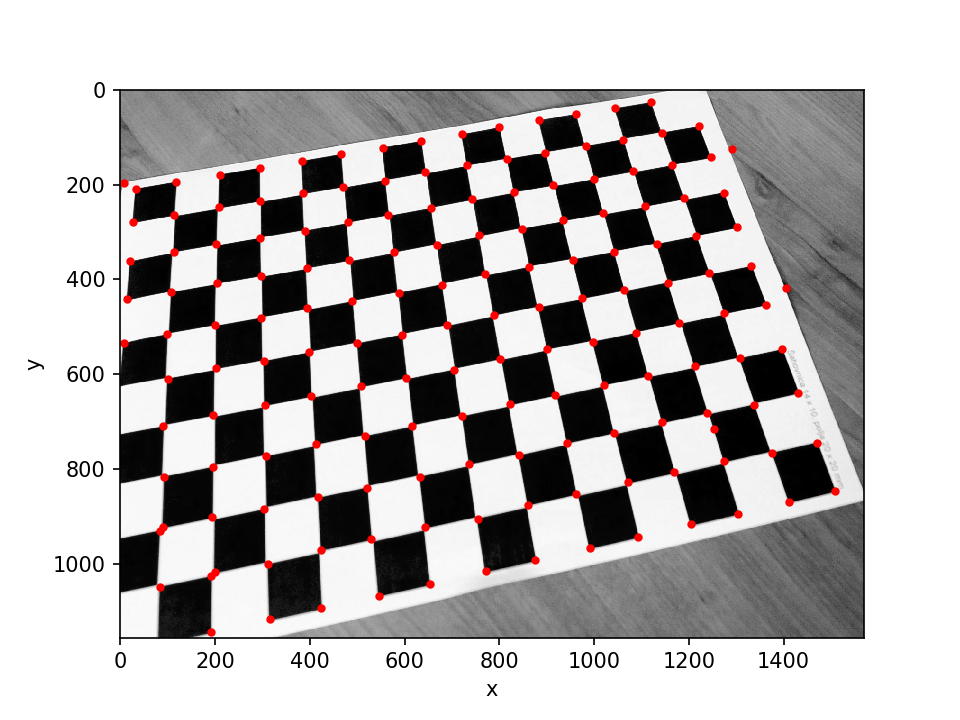

In [12]:
CalibImg = loadImage('data/calibration-object.jpg')
CalibImg = colorToGray(CalibImg)
#showImage(CalibImg)

#harris
maxCorners = 200
qualityLevel = 0.01
minDistance = 10
blockSize = 3
useHarrisDetector = True
k = 1/50
corners = cv.goodFeaturesToTrack(CalibImg, 
                                 maxCorners, 
                                 qualityLevel, 
                                 minDistance,
                                 None,
                                 None,
                                 blockSize,
                                 useHarrisDetector,
                                 k)
corners = np.squeeze(corners)
showImage(CalibImg)
plt.plot(corners[:,0],corners[:,1], 'or', markersize=3.0)

<IPython.core.display.Javascript object>


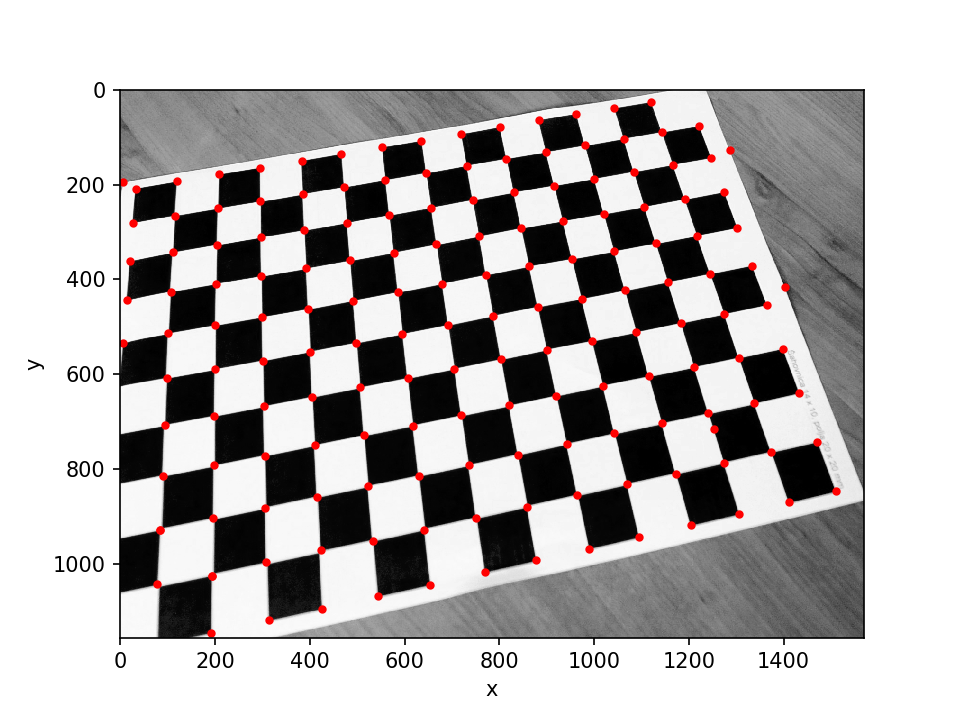

(163, 2)
(163, 2)
199403.11
199403.11


In [313]:
winSize = (5,5)
zeroZero = (-1,-1)
stop_criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER,
                     30, 0.05)
better_corners = cv.cornerSubPix(CalibImg, corners, winSize, zeroZero, stop_criteria)

showImage(CalibImg)
plt.plot(better_corners[:,0],better_corners[:,1], 'or', markersize=3.0)

<IPython.core.display.Javascript object>


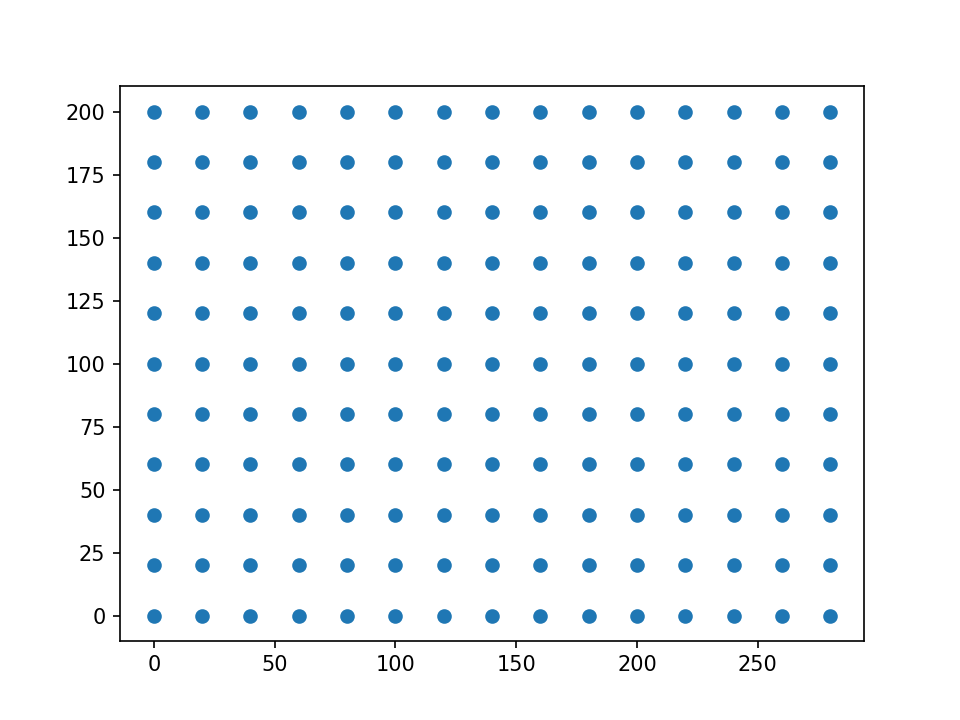

In [31]:
A = np.linspace(0,14*20,15)
B = np.linspace(0,10*20,11)

C1, C2 = np.meshgrid(A, B, sparse=False, indexing='xy')
plt.figure()
plt.scatter(C1, C2)

In [ ]:
#TODO: ICP

![Primer kalibracije](images/RV_7_SLO_PrimerKalibracije.png)